# Health Risk Scoring Model

A machine learning project that predicts a patient's health risk level from clinical and lifestyle data.

The goal is to build a transparent, explainable model that could be used by healthcare providers, insurers, or wellness platforms to identify high-risk individuals and support early interventions.


## Business Understanding
Many healthcare systems struggle to proactively identify patients at high risk of developing
serious conditions. This project explores how tabular clinical data (age, blood pressure,
cholesterol, lifestyle factors, etc.) can be used to build a **health risk scoring model**
that classifies patients into risk segments (e.g. Low, Medium, High).

The objectives of this project are as follows:
- Clean and preprocess a real-world-style health dataset.
- Engineer features suitable for supervised learning.
- Train baseline and advanced models (e.g. Logistic Regression, Tree-based models).
- Evaluate performance with metrics such as ROC-AUC, precision/recall, and calibration.
- Derive interpretable risk scores and visual explanations (e.g. feature importance, SHAP).
- Optionally expose a simple **Streamlit app** to interactively score new patients.

# Data Understanding

This project uses the Framingham Heart Study dataset, a comprehensive collection of patient information from an ongoing cardiovascular study in Framingham, Massachusetts. The dataset aims to predict the 10-year risk of future coronary heart disease (CHD) in patients based on various health attributes. It includes over 4,000 records and 15 attributes, making it a valuable resource for researchers and data scientists working on predictive modeling in healthcare.

## 1. General Imports

In [1]:
## General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)

## 2. Loading the Data

In [2]:
df = pd.read_csv('../data/raw/framingham_heart_study.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## 3. Analyzing the Structure of the Data

In [3]:
df.shape

(4240, 16)

A quick overview of the data shows that it has an extensive set of features that can be used to predict a patient's health risk level based on clinical and lifestyle attributes.

Overall, it has 4240 rows and 16 columns.

# Data Preparation

Let's start by outputting the statistical description of our dataset.

## 1. General Description

In [4]:
# Output statistical description of dataset
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


The statistical description shows that the median age is around 50. About half of the subject are smokers, smoking an average of 9 cigarettes per day. And the average heart rate is about 76.

Let's start by analyzing missing values.

## 2. Missing Values

In [5]:
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Some data is missing for the `education`, `BPMeds`, `totChol`, `BMI`, and `glucose` columns. From those columns, only the `glucose` column has missing values that represent about 10% of the total rows. Since most of those columns are likely to affect a patient's risk of coronary heart disease, we won't drop them. Instead, we'll impute them with the appropriate strategy (`median` for numeric vallues) in the modeling phase. Instead, we'll replace them with sensible defaults.

Let's now output the types of the data in the dataset.

## 3. Dataset Structure

In [6]:
# Output types of data
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

The types of the data reveal some interesting information. First, all features have numeric values. Second, the `education`, `cigsPerDay`, and `BPMeds` columns are of type `float64`. They should be of type `int64`; so let's convert those columns to their appropriate types.

In [7]:
# Convert `float64` columns to their appropriate types.
df['education'] = df['education'].astype('Int64')
df['cigsPerDay'] = df['cigsPerDay'].astype('Int64')
df['BPMeds'] = df['BPMeds'].astype('Int64')
df.dtypes

male                 int64
age                  int64
education            Int64
currentSmoker        int64
cigsPerDay           Int64
BPMeds               Int64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   Int64  
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   Int64  
 5   BPMeds           4187 non-null   Int64  
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: Int64(3), float64(6), int64(7)
memory usage: 542.6 KB


Let's now review the different values for the feature column (`TenYearCHD`)

## 4. Feature Distribution

In [10]:
df['TenYearCHD'].value_counts(normalize = True)

TenYearCHD
0    0.848113
1    0.151887
Name: proportion, dtype: float64

The current distribution of the data shows that about 85% of patients do not have CHD.

Let's now review a chart of those distributions

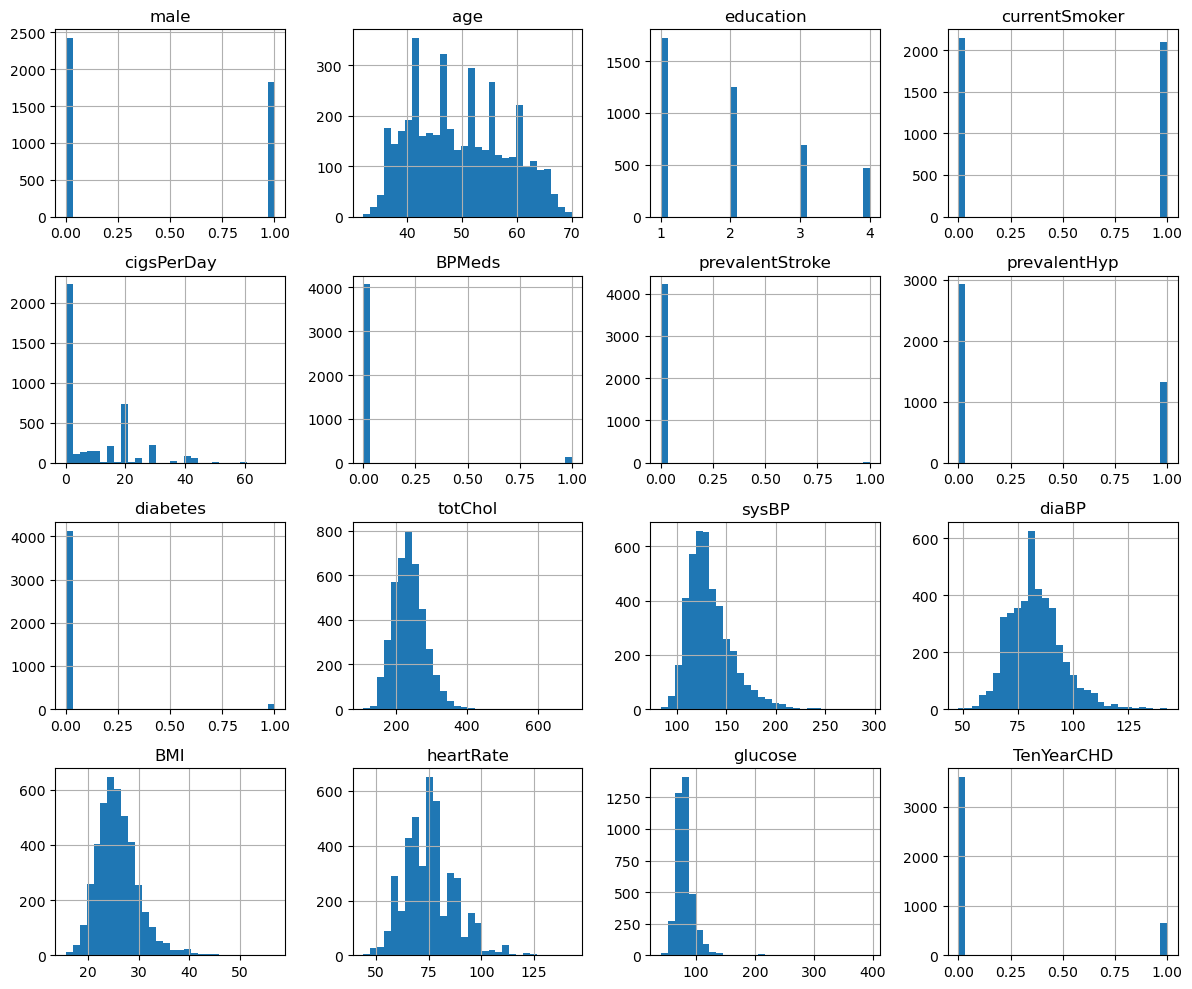

In [17]:
# Plto a bot chart of the `TenYearCHD`
numeric_columns = df.select_dtypes(include = [np.number]).columns.tolist()

df[numeric_columns].hist(figsize = (12, 10), bins = 30)
plt.tight_layout()
plt.show()

Let's show a few targeted plots. First, let's plot a chart that correlates the `age` and `TenYearCHD` columns.

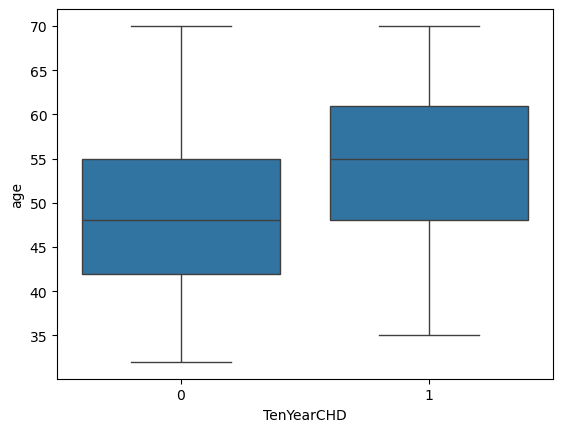

In [21]:
# Draw a chat that correlates the `age` and the `TenYearCHD` columns
sns.boxplot(df, x = 'TenYearCHD', y = 'age')
plt.show()

Next, let's plot another chart that correlates the `totChol` and `TenYearCHD` columns.

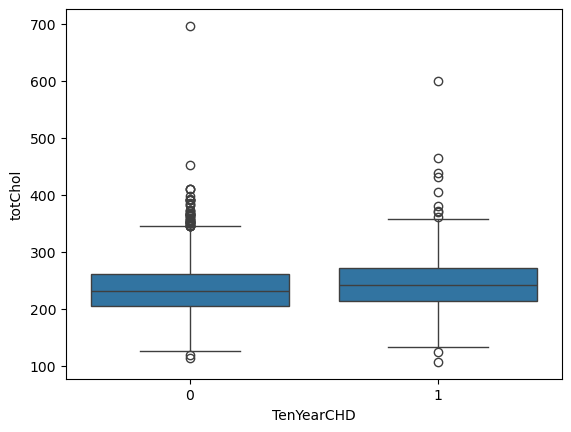

In [22]:
# Draw a chat that correlates the `totChol` and the `TenYearCHD` columns
sns.boxplot(df, x = 'TenYearCHD', y = 'totChol')
plt.show()

## 5. Feature Correlation

Finally, let's build a heatmap chart of the correlation between the features in the dataset.

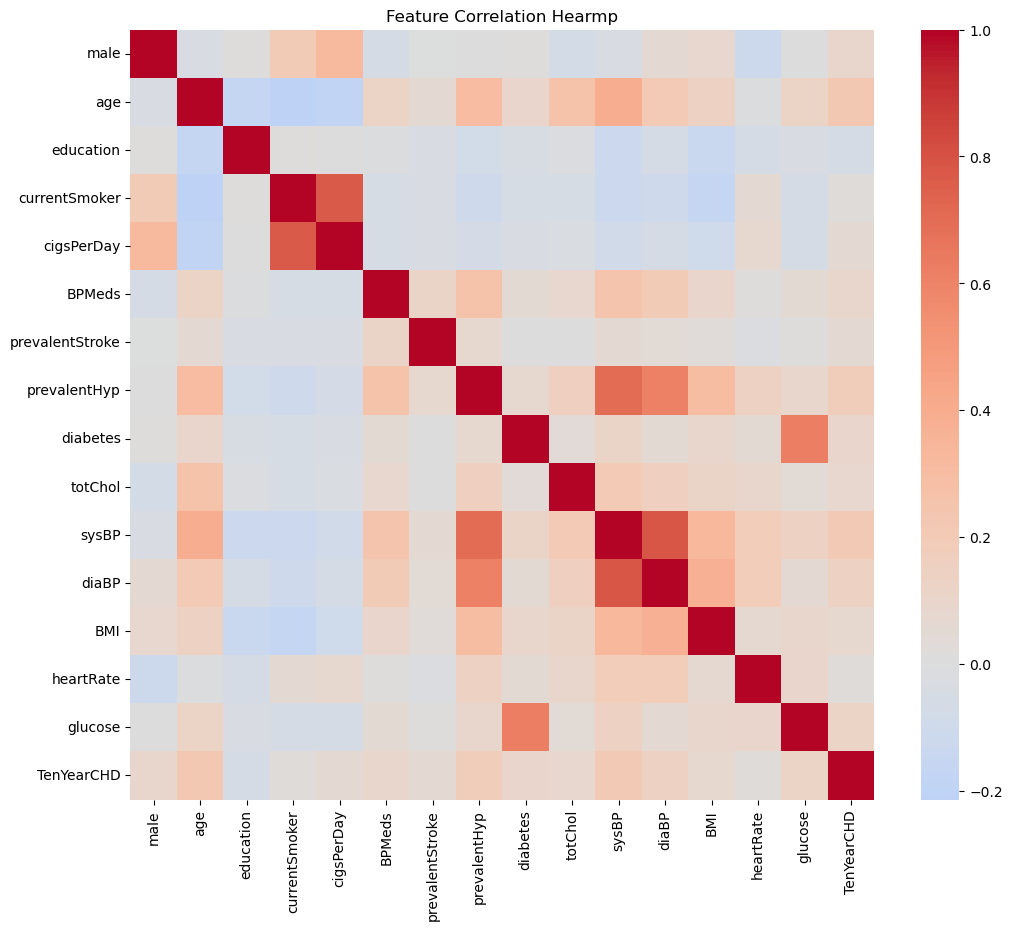

In [24]:
# Draw a chart that shows a correlation between the features in the dataset
corr = df[numeric_columns].corr()
plt.figure(figsize = (12, 10))
sns.heatmap(corr, cmap = 'coolwarm', center = 0)
plt.title('Feature Correlation Hearmp')
plt.show()

## 6. Finding and Notes

- The current distribution of the data shows that about 85% of patients do not have CHD.
- Some data is missing for the education, BPMeds, totChol, BMI, and glucose columns. Because most of those columns are likely to affect a patient's risk of coronary heart disease, we won't drop them. Instead, we'll impute them with the appropriate strategy.
- Age, prevalence of hypertension, systoic BP, cholesterol, and glucose seem correlated with `TenYearCHD`.
- Patients between the ages of 46 and 62 are at a higher risk of being diagnosed with `TenYearCHD`.